In [ ]:
# %pip install tensorflow-addons
# %pip uninstall tensorflow-addons
# %pip install tqdm scikit-learn
# %pip install fastparquet pyarrow
# %pip install tensorflow-addons seaborn fastparquet

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy
import ast
import pyarrow
# import fastparquet

# print(f'Tensorflow V{tf.__version__}')
# print(f'Keras V{tf.keras.__version__}')
# print(f'Python V{sys.version}')

/Users/theerat/Documents/sign-language-translator/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# LSTM

In [2]:
# from sklearn.model_selection import train_test_split
from keras import utils

In [3]:
words = os.listdir('/Users/theerat/Dataset/landmarked')

In [4]:
words.remove('.DS_Store')
# words.remove('ไม่มี')

In [5]:
words

['หนังสือ',
 'อยู่',
 'พูด',
 'อะไร',
 'ไก่ผัดกะเพรา',
 'ปลา',
 'ชอบ',
 'หัวเราะ',
 'ควาย',
 'ไม่มี',
 'ฟัง',
 'ดื่ม',
 'คุณ',
 'นอน',
 'เขา',
 'กิน',
 'โรงเรียน',
 'ฉัน',
 'ที่ไหน',
 'ข้าว',
 'บ้าน',
 'นักเรียน',
 'วันนี้',
 'วิ่ง',
 'เดิน']

In [6]:
words_np = np.array(words)

In [13]:
DATA_PATH = os.path.join('/Users/theerat/Dataset/landmarked')
DATA_PATH_TEST = os.path.join('/Users/theerat/Dataset/test')

In [8]:
label_map = {label:num for num, label in enumerate(words_np)}
label_map

{'หนังสือ': 0,
 'อยู่': 1,
 'พูด': 2,
 'อะไร': 3,
 'ไก่ผัดกะเพรา': 4,
 'ปลา': 5,
 'ชอบ': 6,
 'หัวเราะ': 7,
 'ควาย': 8,
 'ไม่มี': 9,
 'ฟัง': 10,
 'ดื่ม': 11,
 'คุณ': 12,
 'นอน': 13,
 'เขา': 14,
 'กิน': 15,
 'โรงเรียน': 16,
 'ฉัน': 17,
 'ที่ไหน': 18,
 'ข้าว': 19,
 'บ้าน': 20,
 'นักเรียน': 21,
 'วันนี้': 22,
 'วิ่ง': 23,
 'เดิน': 24}

In [9]:
words = label_map.keys()

In [10]:
words

dict_keys(['หนังสือ', 'อยู่', 'พูด', 'อะไร', 'ไก่ผัดกะเพรา', 'ปลา', 'ชอบ', 'หัวเราะ', 'ควาย', 'ไม่มี', 'ฟัง', 'ดื่ม', 'คุณ', 'นอน', 'เขา', 'กิน', 'โรงเรียน', 'ฉัน', 'ที่ไหน', 'ข้าว', 'บ้าน', 'นักเรียน', 'วันนี้', 'วิ่ง', 'เดิน'])

อัดไฟล์

In [11]:
#test
csv_path ='/Users/theerat/Dataset/test/อะไร/2/17.csv'
df = pd.read_csv(csv_path)
frame_data = df.to_numpy()

frame_length = frame_data.size

print(f"Frame shape: {frame_data.shape}")
print(f"Frame length (number of features): {frame_length}")
df

Frame shape: (543, 5)
Frame length (number of features): 2715


,ID,Body Parts,x,y,z
0,0,Right_Hand,0.418898,0.835692,-3.447231e-08
1,1,Right_Hand,0.449275,0.852050,-1.238505e-02
2,2,Right_Hand,0.466917,0.901128,-2.105079e-02
3,3,Right_Hand,0.470475,0.953398,-2.551438e-02
4,4,Right_Hand,0.467545,0.991001,-2.886224e-02
...,...,...,...,...,...
538,538,Face,0.545115,0.245309,6.229683e-03
539,539,Face,0.543440,0.246635,3.367871e-03
540,540,Face,0.542841,0.247402,4.270020e-04
541,541,Face,0.561065,0.243681,1.157804e-02


In [12]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras import utils

sequence_length = 30
frame_length = 1629

sequences = []
labels = []

for action in tqdm(label_map.keys(), desc="Processing Actions"):
    print(f"Processing {action}...")
    
    n_sequences = os.listdir(os.path.join(DATA_PATH, action))
    n_sequences = list(filter(lambda seq: seq != '.DS_Store', n_sequences))
    
    for sequence in tqdm(n_sequences, desc=f"Sequences for {action}", leave=False):
        window = []
        
        for frame_num in range(sequence_length):
            csv_path = os.path.join(DATA_PATH, action, sequence, f'{frame_num}.csv')
            
            if os.path.exists(csv_path):
                df_train = pd.read_csv(csv_path)
                
                df_train = df_train[['x', 'y', 'z']]
                
                frame_data = df_train.to_numpy().flatten()
                
                if len(frame_data) < frame_length:
                    frame_data = np.pad(frame_data, (0, frame_length - len(frame_data)), mode='constant', constant_values=0)
                elif len(frame_data) > frame_length:
                    frame_data = frame_data[:frame_length]
                
                window.append(frame_data)
        
        if len(window) < sequence_length:
            padding_frame = np.zeros((frame_length,))
            for _ in range(sequence_length - len(window)):
                window.append(padding_frame)
        elif len(window) > sequence_length:
            window = window[:sequence_length]
        
        sequences.append(window)
        labels.append(label_map[action])

X_data = np.array(sequences)
y_data = np.array(labels)

y_data = utils.to_categorical(y_data, num_classes=len(label_map))

np.save("X_data.npy", X_data)
np.save("y_data.npy", y_data)

print(X_data.shape)
print(y_data.shape)


Processing Actions:   0%|          | 0/25 [00:00<?, ?it/s]

Processing หนังสือ...


Processing Actions:   4%|▍         | 1/25 [00:01<00:27,  1.15s/it]

Processing อยู่...


Processing Actions:   8%|▊         | 2/25 [00:02<00:24,  1.05s/it]

Processing พูด...


Processing Actions:  12%|█▏        | 3/25 [00:03<00:22,  1.01s/it]

Processing อะไร...


Processing Actions:  16%|█▌        | 4/25 [00:04<00:20,  1.01it/s]

Processing ไก่ผัดกะเพรา...


Processing Actions:  20%|██        | 5/25 [00:04<00:19,  1.04it/s]

Processing ปลา...


Processing Actions:  24%|██▍       | 6/25 [00:05<00:18,  1.04it/s]

Processing ชอบ...


Processing Actions:  28%|██▊       | 7/25 [00:06<00:17,  1.03it/s]

Processing หัวเราะ...


Processing Actions:  32%|███▏      | 8/25 [00:07<00:16,  1.03it/s]

Processing ควาย...


Processing Actions:  36%|███▌      | 9/25 [00:08<00:15,  1.04it/s]

Processing ไม่มี...


Processing Actions:  40%|████      | 10/25 [00:09<00:14,  1.04it/s]

Processing ฟัง...


Processing Actions:  44%|████▍     | 11/25 [00:10<00:13,  1.05it/s]

Processing ดื่ม...


Processing Actions:  48%|████▊     | 12/25 [00:11<00:12,  1.05it/s]

Processing คุณ...


Processing Actions:  52%|█████▏    | 13/25 [00:12<00:11,  1.05it/s]

Processing นอน...


Processing Actions:  56%|█████▌    | 14/25 [00:13<00:10,  1.05it/s]

Processing เขา...


Processing Actions:  60%|██████    | 15/25 [00:14<00:09,  1.05it/s]

Processing กิน...


Processing Actions:  64%|██████▍   | 16/25 [00:15<00:08,  1.05it/s]

Processing โรงเรียน...


Processing Actions:  68%|██████▊   | 17/25 [00:16<00:07,  1.05it/s]

Processing ฉัน...


Processing Actions:  72%|███████▏  | 18/25 [00:17<00:06,  1.05it/s]

Processing ที่ไหน...


Processing Actions:  76%|███████▌  | 19/25 [00:18<00:05,  1.05it/s]

Processing ข้าว...


Processing Actions:  80%|████████  | 20/25 [00:19<00:04,  1.04it/s]

Processing บ้าน...


Processing Actions:  84%|████████▍ | 21/25 [00:20<00:03,  1.03it/s]

Processing นักเรียน...


Processing Actions:  88%|████████▊ | 22/25 [00:21<00:02,  1.03it/s]

Processing วันนี้...


Processing Actions:  92%|█████████▏| 23/25 [00:22<00:01,  1.04it/s]

Processing วิ่ง...


Processing Actions:  96%|█████████▌| 24/25 [00:23<00:00,  1.04it/s]

Processing เดิน...


Processing Actions: 100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


Data saved to 'X_data.npy' with shape: (625, 30, 1629)
Labels saved to 'y_data.npy' with shape: (625, 25)


In [14]:
sequence_length = 30
frame_length = 1629

sequences_test = []
labels_test = []

for action in tqdm(label_map.keys(), desc="Processing Actions"):
    print(f"Processing {action}...")
    
    n_sequences = os.listdir(os.path.join(DATA_PATH_TEST, action))
    n_sequences = list(filter(lambda seq: seq != '.DS_Store', n_sequences))
    
    for sequence in tqdm(n_sequences, desc=f"Sequences for {action}", leave=False):
        window = []
        
        for frame_num in range(sequence_length):
            csv_path = os.path.join(DATA_PATH_TEST, action, sequence, f'{frame_num}.csv')
            
            if os.path.exists(csv_path):
                df_test = pd.read_csv(csv_path)
                
                df_test = df_test[['x', 'y', 'z']]
                
                frame_data = df_test.to_numpy().flatten()
                
                if len(frame_data) < frame_length:
                    frame_data = np.pad(frame_data, (0, frame_length - len(frame_data)), mode='constant', constant_values=0)
                elif len(frame_data) > frame_length:
                    frame_data = frame_data[:frame_length]
                
                window.append(frame_data)
        
        if len(window) < sequence_length:
            padding_frame = np.zeros((frame_length,))
            for _ in range(sequence_length - len(window)):
                window.append(padding_frame)
        elif len(window) > sequence_length:
            window = window[:sequence_length]
        
        sequences_test.append(window)
        labels_test.append(label_map[action])

X_test = np.array(sequences_test)
y_test = np.array(labels_test)

y_test = utils.to_categorical(y_test, num_classes=len(label_map))

# บันทึกเป็นไฟล์ npy
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

print({X_test.shape})
print({y_test.shape})


Processing Actions:   0%|          | 0/25 [00:00<?, ?it/s]

Processing หนังสือ...


Processing Actions:   4%|▍         | 1/25 [00:00<00:05,  4.02it/s]

Processing อยู่...


Processing Actions:   8%|▊         | 2/25 [00:00<00:05,  4.53it/s]

Processing พูด...


Processing Actions:  12%|█▏        | 3/25 [00:00<00:04,  4.62it/s]

Processing อะไร...


Processing Actions:  16%|█▌        | 4/25 [00:00<00:04,  4.63it/s]

Processing ไก่ผัดกะเพรา...


Processing Actions:  20%|██        | 5/25 [00:01<00:04,  4.55it/s]

Processing ปลา...


Processing Actions:  24%|██▍       | 6/25 [00:01<00:04,  4.74it/s]

Processing ชอบ...


Processing Actions:  28%|██▊       | 7/25 [00:01<00:03,  4.85it/s]

Processing หัวเราะ...


Processing Actions:  32%|███▏      | 8/25 [00:01<00:03,  4.92it/s]

Processing ควาย...


Processing Actions:  36%|███▌      | 9/25 [00:01<00:03,  4.99it/s]

Processing ไม่มี...


Processing Actions:  40%|████      | 10/25 [00:02<00:03,  4.98it/s]

Processing ฟัง...


Processing Actions:  44%|████▍     | 11/25 [00:02<00:02,  5.01it/s]

Processing ดื่ม...


Processing Actions:  48%|████▊     | 12/25 [00:02<00:02,  5.03it/s]

Processing คุณ...


Processing Actions:  52%|█████▏    | 13/25 [00:02<00:02,  5.08it/s]

Processing นอน...


Processing Actions:  56%|█████▌    | 14/25 [00:02<00:02,  5.08it/s]

Processing เขา...


Processing Actions:  60%|██████    | 15/25 [00:03<00:01,  5.12it/s]

Processing กิน...


Processing Actions:  64%|██████▍   | 16/25 [00:03<00:01,  5.14it/s]

Processing โรงเรียน...


Processing Actions:  68%|██████▊   | 17/25 [00:03<00:01,  4.65it/s]

Processing ฉัน...


Processing Actions:  72%|███████▏  | 18/25 [00:03<00:01,  4.76it/s]

Processing ที่ไหน...


Processing Actions:  76%|███████▌  | 19/25 [00:03<00:01,  4.89it/s]

Processing ข้าว...


Processing Actions:  80%|████████  | 20/25 [00:04<00:01,  4.99it/s]

Processing บ้าน...


Processing Actions:  84%|████████▍ | 21/25 [00:04<00:00,  5.05it/s]

Processing นักเรียน...


Processing Actions:  88%|████████▊ | 22/25 [00:04<00:00,  5.08it/s]

Processing วันนี้...


Processing Actions:  92%|█████████▏| 23/25 [00:04<00:00,  5.10it/s]

Processing วิ่ง...


Processing Actions:  96%|█████████▌| 24/25 [00:04<00:00,  5.11it/s]

Processing เดิน...


Processing Actions: 100%|██████████| 25/25 [00:05<00:00,  4.93it/s]


Data saved to 'X_data.npy' with shape: (125, 30, 1629)
Labels saved to 'y_data.npy' with shape: (125, 25)


In [15]:
df = pd.DataFrame({'sequence':sequences, 'label':labels})
df

,sequence,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
...,...,...
620,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",24
621,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",24
622,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",24
623,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",24


In [16]:
df2 = pd.DataFrame({'sequence':sequences_test, 'label':labels_test})
df2

,sequence,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
...,...,...
120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",24
121,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",24
122,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",24
123,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",24


In [19]:
# Sequence in row 2
sequence_row_2 = df.loc[30, 'sequence']
label_row_2 = df.loc[30, 'label']

print(f"Label in row 2: {label_row_2}")
print(f"Sequence length in row 2: {len(sequence_row_2)}\n")

print("Frames in the sequence:")
for idx, frame in enumerate(sequence_row_2):
    print(f"Frame {idx}: {frame}\n")


Label in row 2: 1
Sequence length in row 2: 30

Frames in the sequence:
Frame 0: [0.         0.         0.         ... 0.53033179 0.37158588 0.01131361]

Frame 1: [0.         0.         0.         ... 0.53049022 0.37136891 0.01118122]

Frame 2: [0.         0.         0.         ... 0.53017008 0.37098739 0.01112173]

Frame 3: [0.         0.         0.         ... 0.53051043 0.37118199 0.01114476]

Frame 4: [0.         0.         0.         ... 0.53086782 0.37145445 0.01132558]

Frame 5: [0.         0.         0.         ... 0.53168094 0.37137282 0.01099719]

Frame 6: [0.         0.         0.         ... 0.53239346 0.37077534 0.01077141]

Frame 7: [0.         0.         0.         ... 0.53283763 0.37177992 0.01181504]

Frame 8: [0.         0.         0.         ... 0.53288168 0.37139326 0.01169165]

Frame 9: [0.         0.         0.         ... 0.53302503 0.3718394  0.01096515]

Frame 10: [ 4.02265310e-01  8.25550258e-01 -1.13696537e-07 ...  5.31070113e-01
  3.81635845e-01  8.03083926e

In [20]:
np.save('s_train_fix.npy', X_data)
np.save('l_train_fix.npy', y_data)
np.save('s_test_fix.npy', X_test)
np.save('l_test_fix.npy', y_test)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [17]:
X_data.shape, X_test.shape, y_data.shape, y_test.shape    

((625, 30, 1629), (125, 30, 1629), (625, 25), (125, 25))

In [20]:
y_train_sparse = np.argmax(y_data, axis=-1)
y_train_sparse

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  9

__New Model__

In [21]:
from keras import models, layers, callbacks
from keras import callbacks, Model, Input

In [22]:
# include early stopping and reducelr
def get_callbacks():
    return [
        callbacks.EarlyStopping(
            monitor="val_accuracy", patience=10, restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_accuracy", factor=0.5, patience=3
        ),
    ]


# a single dense block followed by a normalization block and relu activation
def dense_block(units, name):
    fc = layers.Dense(units)
    norm = layers.LayerNormalization()
    act = layers.Activation("relu")
    drop = layers.Dropout(0.1)
    return lambda x: drop(act(norm(fc(x))))


# the lstm block with the final dense block for the classification
def classifier(lstm_units):
    lstm = layers.LSTM(lstm_units)
    out = layers.Dense(25, activation="softmax")
    return lambda x: out(lstm(x))

In [23]:
import tensorflow as tf
from keras import layers, Model, Input, callbacks,optimizers

encoder_units = [512, 256]
lstm_units = 500  

inputs = Input(shape=(30, 1629))

x = inputs
for i, n in enumerate(encoder_units):
    x = dense_block(n, f"encoder_{i}")(x)

out = classifier(lstm_units)(x)

model = Model(inputs=inputs, outputs=out)
model.compile(optimizer=optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
callbacks_list = get_callbacks()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1629)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30, 512)        │       834,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 30, 512)        │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 30, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 500)            │     1,514,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │        12,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,493,949 (9.51 MB)

 Trainable params: 2,493,949 (9.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import visualkeras
from PIL import ImageFont
# font = ImageFont.truetype("SukhumvitSet-Medium.ttf", 9)
visualkeras.layered_view(model, legend=True,spacing=300)

In [24]:
history = model.fit(
                    X_data,
                    y_data,
                    epochs=100,
                    batch_size=32,
                    # validation_split=0.2,
                    # callbacks=callbacks_list,
                    # verbose=1
                    )

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.0518 - loss: 3.2949
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.1616 - loss: 2.5626
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.3267 - loss: 1.8422
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.4034 - loss: 1.5291
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.4608 - loss: 1.3534
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.4231 - loss: 1.4146
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.5396 - loss: 1.1922
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.5204 - loss: 1.2792
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.4996 - loss: 1.1532
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.6439 - loss: 0.9783
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.6440 - loss: 0.8680
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5

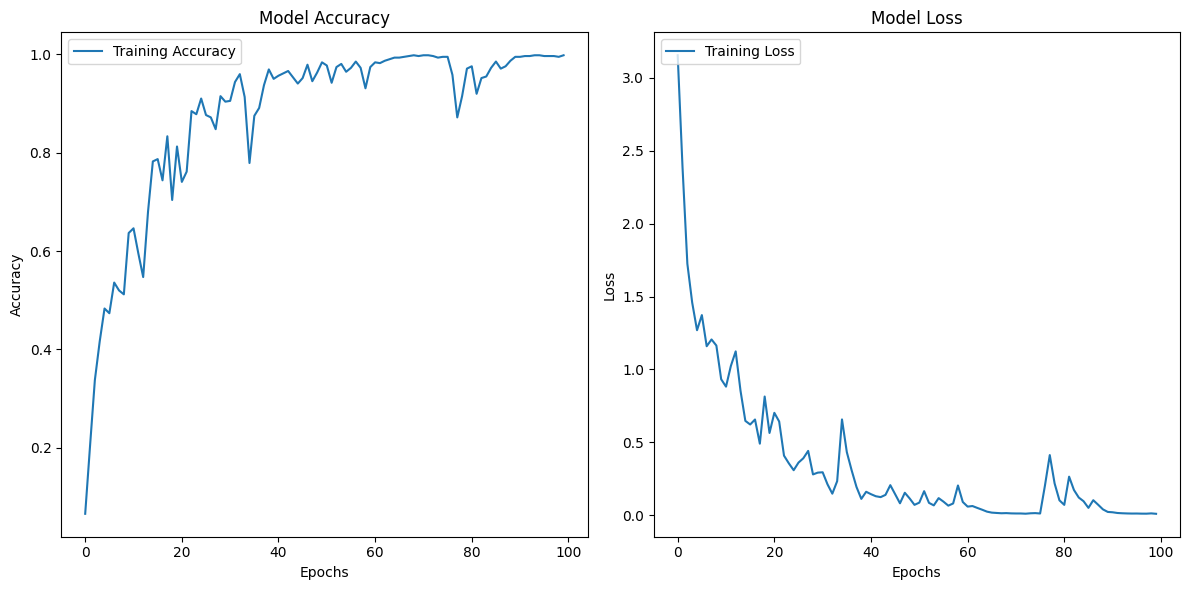

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


In [46]:
model.save('model_25_2_fix_2.h5')
model.save_weights('weights_25_2_fix_2.weights.h5')

In [28]:
X_test.shape, y_test.shape

((125, 30, 1629), (125, 25))

In [29]:
labels_predict = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


In [30]:
labels_predict.shape

(125, 25)

In [31]:
# Decoding
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(y_test , axis=1)

In [32]:
labels_test_normal.shape , labels_predict.shape

((125,), (125,))

In [33]:
labels_predict

array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2, 13,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6, 13,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20,
       20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24])

In [34]:
#Accuracy Score
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.976


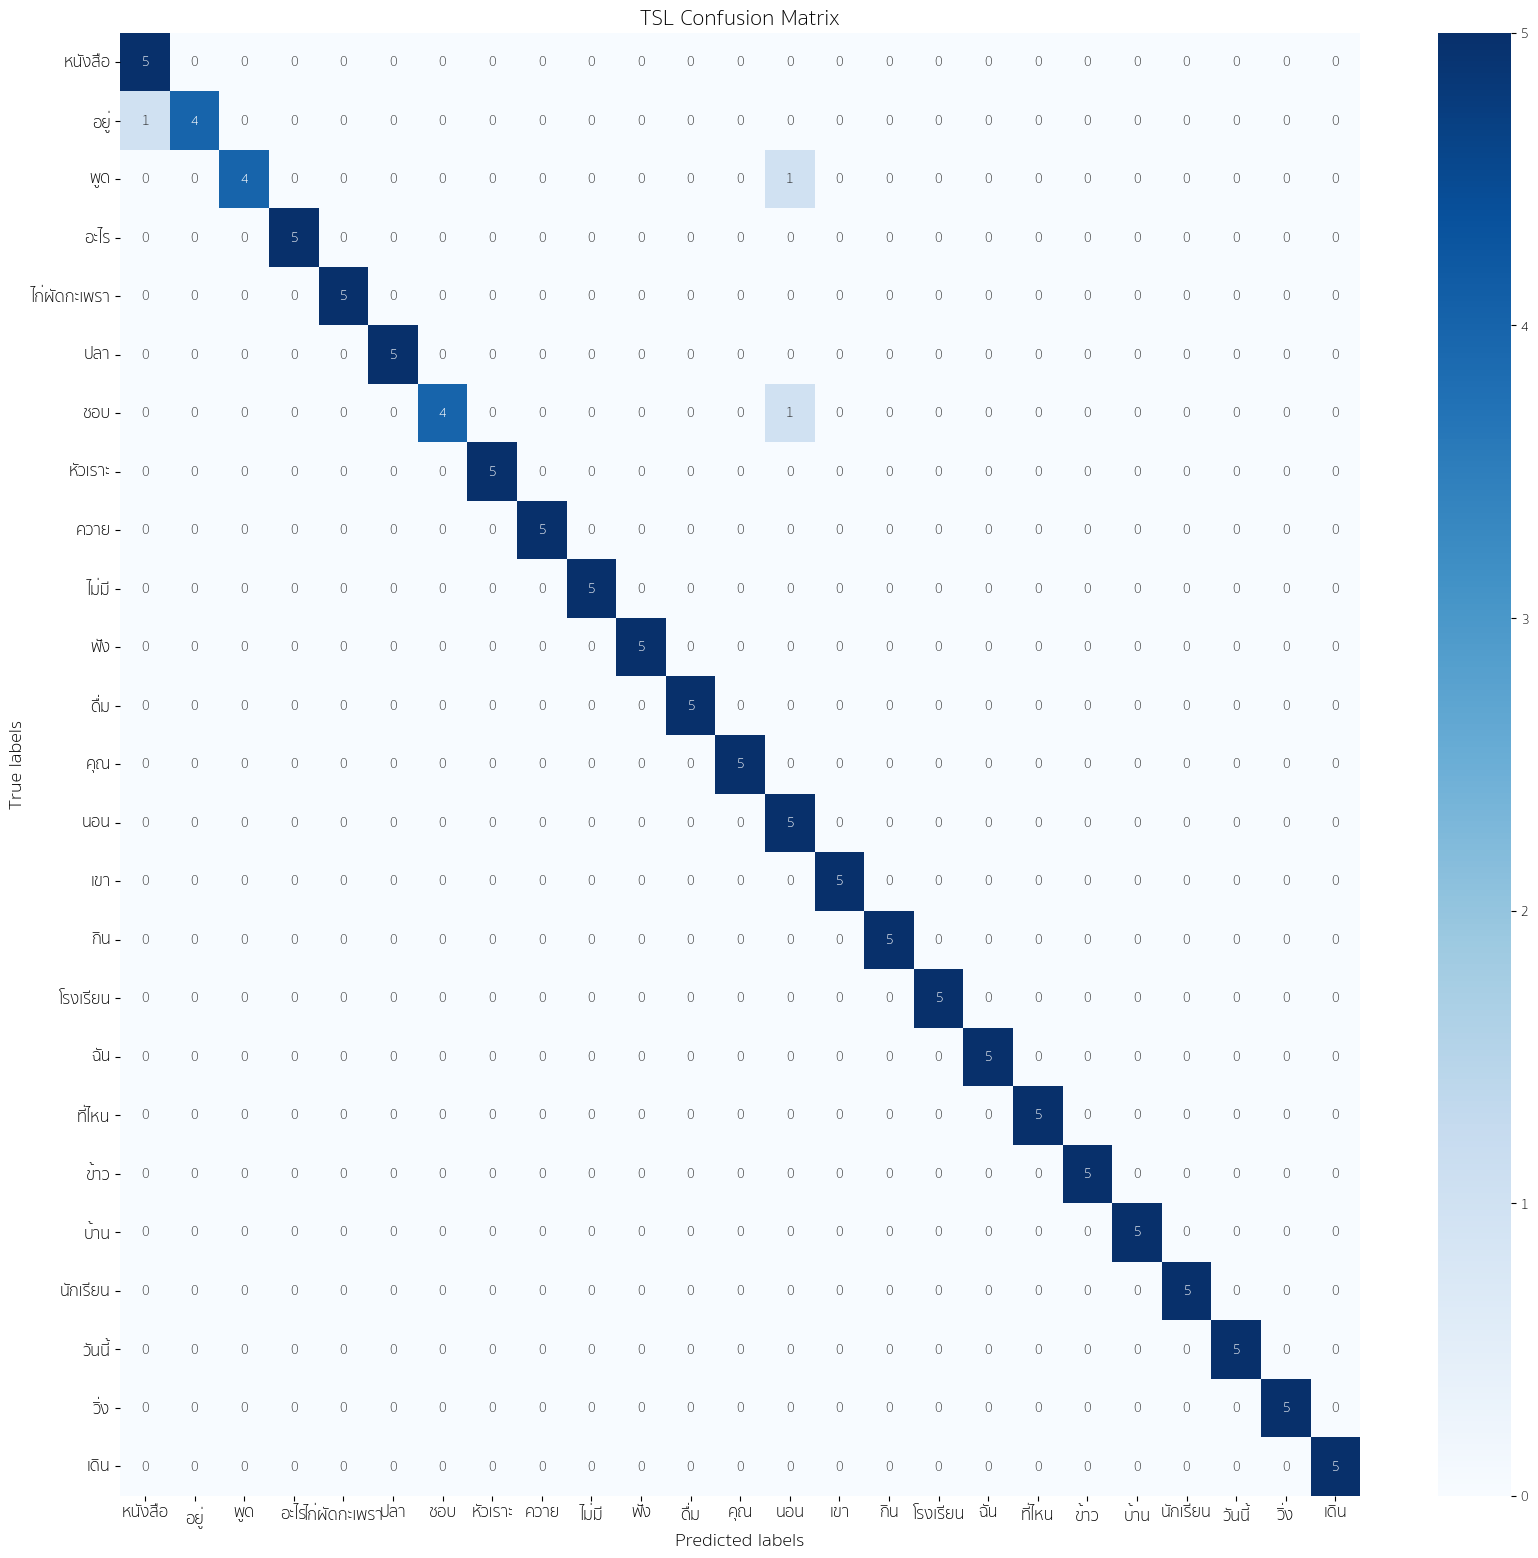

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc

thai_font_path = "/Users/theerat/Documents/sign-language-translator/Datasets/SukhumvitSet-Medium.ttf"  # หรือพาธที่ตรงกับระบบของคุณ
font_prop = matplotlib.font_manager.FontProperties(fname=thai_font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

class_labels = words


cm = confusion_matrix(labels_test_normal, labels_predict)

fig, ax = plt.subplots(figsize=(20, 19))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues")

ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('TSL Confusion Matrix', fontsize=16)

ax.set_xticklabels(class_labels, rotation=0, fontsize=12)
ax.set_yticklabels(class_labels, rotation=0, fontsize=12)

plt.show()


In [36]:
print(cm)

[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 

In [37]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       0.71      1.00      0.83         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         

In [39]:
label_map

{'หนังสือ': 0,
 'อยู่': 1,
 'พูด': 2,
 'อะไร': 3,
 'ไก่ผัดกะเพรา': 4,
 'ปลา': 5,
 'ชอบ': 6,
 'หัวเราะ': 7,
 'ควาย': 8,
 'ไม่มี': 9,
 'ฟัง': 10,
 'ดื่ม': 11,
 'คุณ': 12,
 'นอน': 13,
 'เขา': 14,
 'กิน': 15,
 'โรงเรียน': 16,
 'ฉัน': 17,
 'ที่ไหน': 18,
 'ข้าว': 19,
 'บ้าน': 20,
 'นักเรียน': 21,
 'วันนี้': 22,
 'วิ่ง': 23,
 'เดิน': 24}

In [38]:
len(cm)

25

In [55]:
actions = os.listdir('/Users/theerat/Dataset/test')

In [56]:
actions.remove(".DS_Store")

In [45]:
actions[np.argmax(y_test[4])]

'หนังสือ'

# __Test__

In [62]:
import cv2
import numpy as np
import mediapipe as mp
from keras import models
from PIL import ImageFont, ImageDraw, Image


colors = [(np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)) for _ in range(len(actions))]

def extract_data_fixed(results):
    """ดึงข้อมูล 541 ตำแหน่งแบบ fix และเติมค่า 0.0 หากไม่มีตำแหน่ง"""
    data = []

    def get_fixed_landmarks(num_points, landmarks):
        fixed_data = []
        for i in range(num_points):
            if landmarks and i < len(landmarks.landmark):
                landmark = landmarks.landmark[i]
                fixed_data.extend([landmark.x, landmark.y, landmark.z])
            else:
                fixed_data.extend([0.0, 0.0, 0.0])
        return fixed_data

    data.extend(get_fixed_landmarks(21, results.right_hand_landmarks))
    data.extend(get_fixed_landmarks(21, results.left_hand_landmarks))
    data.extend(get_fixed_landmarks(33, results.pose_landmarks))
    data.extend(get_fixed_landmarks(468, results.face_landmarks))

    return np.array(data, dtype=np.float32)

# Model
model = models.load_model('model_25_2_fix_2.h5')

# Font
font_path = '/Users/theerat/Documents/sign-language-translator/Datasets/SukhumvitSet-Medium.ttf'
font = ImageFont.truetype(font_path, 55)

video_path = "/Users/theerat/Dataset/all_words/ที่ไหน/video_19.mp4"
cap = cv2.VideoCapture(video_path)

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils


output_path = "output_video.mp4"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# ตั้งความถี่
frame_count = 0
prediction_interval = 30


with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.1) as holistic:
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.5

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = holistic.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)

        keypoints = extract_data_fixed(results)

        if len(keypoints) == 543 * 3:
            sequence.append(keypoints)

        if len(sequence) > 30:
            sequence = sequence[-30:]

        if frame_count % prediction_interval == 0 and len(sequence) == 30:
            input_data = np.expand_dims(np.array(sequence), axis=0)
            res = model.predict(input_data)[0]
            predictions.append(np.argmax(res))

            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

        frame_count += 1

        cv2.rectangle(image, (0, 0), (640, 100), (0, 102, 255), -1)

        img_pil = Image.fromarray(image)
        draw = ImageDraw.Draw(img_pil)
        draw.text((10, 30), ' '.join(sentence), font=font, fill=(255, 255, 255, 255))  # ข้อความแสดงผล
        image = np.array(img_pil)

        out.write(image)

        cv2.imshow('Video Test', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
out.release()
cv2.destroyAllWindows()


I0000 00:00:1736078310.490961 1750112 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2
W0000 00:00:1736078310.665718 1799331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1736078310.690830 1799331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1736078310.695419 1799331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1736078310.696279 1799330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1736078310.696877 1799333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
